In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob

# Temperature

In [2]:
def extraer_temperatura(nombre_archivo):
    match = re.search(r'(\d+\.\d+|\d+)K', nombre_archivo)
    if match:
        return float(match.group(1))
    else:
        return None
        

In [38]:
sample = '24000'
carpeta = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\SnTe\{sample}\{sample}'
carpeta_ref = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\SnTe\{sample}\Subs'

In [39]:
prueb1 = '20240924-143444__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__276.7K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms'
prueb2 = '20240924-150016__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__144.3K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms'

print(extraer_temperatura(prueb1))
print(extraer_temperatura(prueb2))


276.7
144.3


In [40]:
def apply_window(params):
    """
    Aplica una ventana de scipy a una señal.

    Parámetros:
    - params (list): Lista con los siguientes elementos:
      1. Nombre de la ventana (str).
      2. Tamaño de la ventana (M) (int).
      3. Parámetros adicionales de la ventana (opcional).

    Retorna:
    - ventana (array): La ventana calculada.
    """
    try:
        # Extrae el nombre de la ventana y el tamaño M de la lista
        window_name = params[0]
        M = params[1]
        extra_params = params[2:]  # Parámetros adicionales para la ventana

        # Obtiene la función de ventana a partir del nombre
        window_func = getattr(win, window_name)
        
        # Aplica la ventana con M como primer argumento y los parámetros adicionales
        window = window_func(M, *extra_params)
        return window
    except AttributeError:
        raise ValueError(f"Ventana '{window_name}' no está disponible en scipy.signal.windows.")
    except TypeError as e:
        raise ValueError(f"Error al pasar los parámetros a la ventana: {e}")

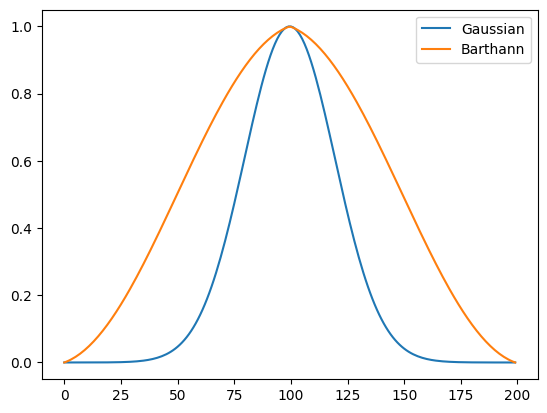

In [41]:
window1 = apply_window(['gaussian', 200,20])
window2 = apply_window(['barthann',200])

plt.plot(window1,label='Gaussian')
plt.plot(window2,label='Barthann')
plt.legend()

# Agrupar_por_rango_temperatura

In [42]:
def agrupar_por_rango_temperatura(archivos_por_temp, rangos):
    '''
    Función encargada de tomar el diccionario or
    '''
    
    archivos_por_rango = {rango: [] for rango in rangos}
    for temp, archivos in archivos_por_temp.items():
        for rango in rangos:
            if rango[0] <= temp < rango[1]:  # Verifica si la temperatura está dentro del rango
                archivos_por_rango[rango].extend(archivos)
                break  # Detiene el ciclo una vez que encuentra el rango correcto

    archivos_por_rango  = {k: v for k, v in archivos_por_rango .items() if v}
    
    return archivos_por_rango


def generar_rangos(min_temp, max_temp, paso):
    rangos = []
    if paso == 0:
        return None
    else:
        for i in np.arange(min_temp, max_temp+paso, paso):
            rangos.append((i, i + paso))
        return rangos

In [43]:
archivos = [archivo for archivo in os.listdir(carpeta) if archivo.endswith('.dat')]
archivos_por_temp = {}
temperaturas = []

for archivo in archivos:
    temp = extraer_temperatura(archivo)
    if temp is not None:
        temperaturas.append(temp)
        archivos_por_temp.setdefault(temp, []).append(archivo)

if not temperaturas:
    print("No se encontraron temperaturas en los archivos.")

archivos_por_temp = dict(sorted(archivos_por_temp.items()))
min_temp = min(temperaturas)
max_temp = max(temperaturas)

In [44]:
archivos_por_temp

{9.8: ['20240924-152355__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__9.8K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat',
  '20240924-154121__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__9.8K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpOFF-100ms.dat'],
 10.1: ['20240924-152206__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__10.1K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat'],
 11.9: ['20240924-152017__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__11.9K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat'],
 14.6: ['20240924-154310__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__14.6K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpOFF-100ms.dat'],
 16.0: ['20240924-151829__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__16.0K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat'],
 19.4: ['20240924-154500__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__19.4K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-H

In [46]:
rangos_temperatura = generar_rangos(min_temp, max_temp, 5)
print(rangos_temperatura[-1])

(294.8, 299.8)


: 

In [33]:
archivos_por_rango = agrupar_por_rango_temperatura(archivos_por_temp, rangos_temperatura)

In [37]:
archivos_por_rango[(9.8,12.8)]

['20240924-152355__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__9.8K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat',
 '20240924-154121__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__9.8K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpOFF-100ms.dat',
 '20240924-152206__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__10.1K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat',
 '20240924-152017__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__11.9K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat']

In [34]:
for rango, lista_archivos in archivos_por_rango.items():
    print(lista_archivos)


['20240924-152355__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__9.8K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat', '20240924-154121__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__9.8K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpOFF-100ms.dat', '20240924-152206__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__10.1K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat', '20240924-152017__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__11.9K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat']
['20240924-154310__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__14.6K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpOFF-100ms.dat']
['20240924-151829__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__16.0K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpON-100ms.dat']
['20240924-154500__Esteban__THZ59.5-62.5__PMP0__S2207L__10RH__19.4K__PTFEwindows+3mmHole+24000__Hpol-300nmSnTe-Bi0.02-HePumpOFF-100ms.dat', '20240924-151640__Esteban__TH